# 04 - Delivery Routing

This notebook demonstrates the **Router** module for delivery planning and route optimization.

## What we'll do:
1. Load forecasts from previous stage
2. Generate customer locations
3. Distribute demand to customers
4. Assign deliveries to trucks
5. Optimize delivery routes
6. Visualize routes and analyze efficiency

In [1]:
import sys
sys.path.insert(0, '..')

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from router.router import Router

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✅ Imports successful!")

✅ Imports successful!


## 1. Load Forecasts from Previous Stage

In [2]:
# Load forecasts
forecasts = pd.read_csv('../output/02_forecasts.csv')
forecasts['date'] = pd.to_datetime(forecasts['date'])

print(f"📊 Loaded {len(forecasts)} forecast records")
print(f"📅 Date range: {forecasts['date'].min()} to {forecasts['date'].max()}")

# Focus on test period (future forecasts)
test_forecasts = forecasts[forecasts['sample'] == 'test'].copy()
print(f"\n🎯 Test forecasts: {len(test_forecasts)} records")
test_forecasts.head()

📊 Loaded 336 forecast records
📅 Date range: 2024-01-07 00:00:00 to 2025-01-26 00:00:00

🎯 Test forecasts: 24 records


,store,product,date,sales,sample,prediction
52,A,A,2025-01-05,NaN,test,198.04625
53,A,A,2025-01-12,NaN,test,211.04164
54,A,A,2025-01-19,NaN,test,220.02122
55,A,A,2025-01-26,NaN,test,227.03943
108,A,B,2025-01-05,NaN,test,160.91020


## 2. Initialize Router and Generate Customers

In [ ]:
# Initialize router
router = Router(
    primary_keys=['store', 'product'],
    date_col='date',
    target_col='sales',
    max_payload=100,
    origin='08020'
)

print("✅ Router initialized")
print(f"   Max Payload: {router.max_payload} units/truck")
print(f"   Origin: {router.origin}")

# Generate customer locations
n_customers = 30
customers = router.generate_customers(n_customers=n_customers)

print(f"\n👥 Generated {len(customers)} customers")
print(f"\nCustomer sample:")
customers.head(10)

✅ Router initialized
   Max Payload: 100 units/truck
   Origin: 08020

👥 Generated 30 customers

Customer sample:


,customer_id,destination
0,CUST_0001,44934
1,CUST_0002,60447
2,CUST_0003,55458
3,CUST_0004,42442
4,CUST_0005,77991
5,CUST_0006,24156
6,CUST_0007,18058
7,CUST_0008,93324
8,CUST_0009,90966
9,CUST_0010,64326


## 3. Distribute Demand to Customers

In [4]:
# Distribute forecasted demand to customers
print("📦 Distributing demand to customers...\n")
deliveries = router.distribute_demand(forecasts)

print(f"✅ Created {len(deliveries)} delivery records")
print(f"\nDelivery columns: {list(deliveries.columns)}")
print(f"\nSample deliveries:")
deliveries.head(10)

📦 Distributing demand to customers...

✅ Created 86 delivery records

Delivery columns: ['store', 'product', 'date', 'sales', 'customer', 'destination', 'units']

Sample deliveries:


,store,product,date,sales,customer,destination,units
0,A,A,2025-01-05,198.04625,CUST_0003,55458,66.015417
1,A,A,2025-01-05,198.04625,CUST_0004,42442,66.015417
2,A,A,2025-01-05,198.04625,CUST_0030,30023,66.015417
3,A,A,2025-01-12,211.04164,CUST_0014,48851,52.760410
4,A,A,2025-01-12,211.04164,CUST_0029,13081,52.760410
5,A,A,2025-01-12,211.04164,CUST_0001,44934,52.760410
6,A,A,2025-01-12,211.04164,CUST_0024,44468,52.760410
7,A,A,2025-01-19,220.02122,CUST_0020,20754,44.004244
8,A,A,2025-01-19,220.02122,CUST_0021,37094,44.004244
9,A,A,2025-01-19,220.02122,CUST_0002,60447,44.004244


In [5]:
# Analyze demand distribution
print("📊 Demand Distribution Analysis:")
print(f"\n   Total demand: {deliveries['units'].sum():.2f} units")
print(f"   Average delivery size: {deliveries['units'].mean():.2f} units")
print(f"   Unique customers: {deliveries['customer'].nunique()}")
print(f"   Unique dates: {deliveries['date'].nunique()}")

# Demand by date
print(f"\n📅 Demand by Date:")
date_summary = deliveries.groupby('date')['units'].agg(['count', 'sum']).round(2)
date_summary.columns = ['# Deliveries', 'Total Units']
print(date_summary)

📊 Demand Distribution Analysis:

   Total demand: 4837.83 units
   Average delivery size: 56.25 units
   Unique customers: 29
   Unique dates: 4

📅 Demand by Date:
            # Deliveries  Total Units
date                                 
2025-01-05            24      1114.43
2025-01-12            23      1195.05
2025-01-19            21      1247.00
2025-01-26            18      1281.36


## 4. Assign Deliveries to Trucks

In [6]:
# Assign trucks based on payload constraints
print("🚚 Assigning deliveries to trucks...\n")
deliveries_with_trucks = router.assign_trucks(deliveries)

n_trucks = deliveries_with_trucks['truck'].nunique()
print(f"✅ Assigned deliveries to {n_trucks} trucks")

# Analyze truck utilization
print(f"\n📊 Truck Utilization:")
truck_summary = deliveries_with_trucks.groupby('truck')['units'].agg(['count', 'sum']).round(2)
truck_summary.columns = ['# Deliveries', 'Total Load']
truck_summary['Utilization %'] = (truck_summary['Total Load'] / router.max_payload * 100).round(1)
print(truck_summary)

🚚 Assigning deliveries to trucks...

✅ Assigned deliveries to 16 trucks

📊 Truck Utilization:
          # Deliveries  Total Load  Utilization %
truck                                            
truck_1              7      321.59          321.6
truck_10             6      322.42          322.4
truck_11             6      304.01          304.0
truck_12             6      260.01          260.0
truck_13             5      342.64          342.6
truck_14             6      238.15          238.2
truck_15             5      398.59          398.6
truck_16             3      107.67          107.7
truck_2              7      356.90          356.9
truck_3              6      274.13          274.1
truck_4              5      247.12          247.1
truck_5              4      246.79          246.8
truck_6              4      442.46          442.5
truck_7              4      256.27          256.3
truck_8              6      372.44          372.4
truck_9              6      346.65          346.6


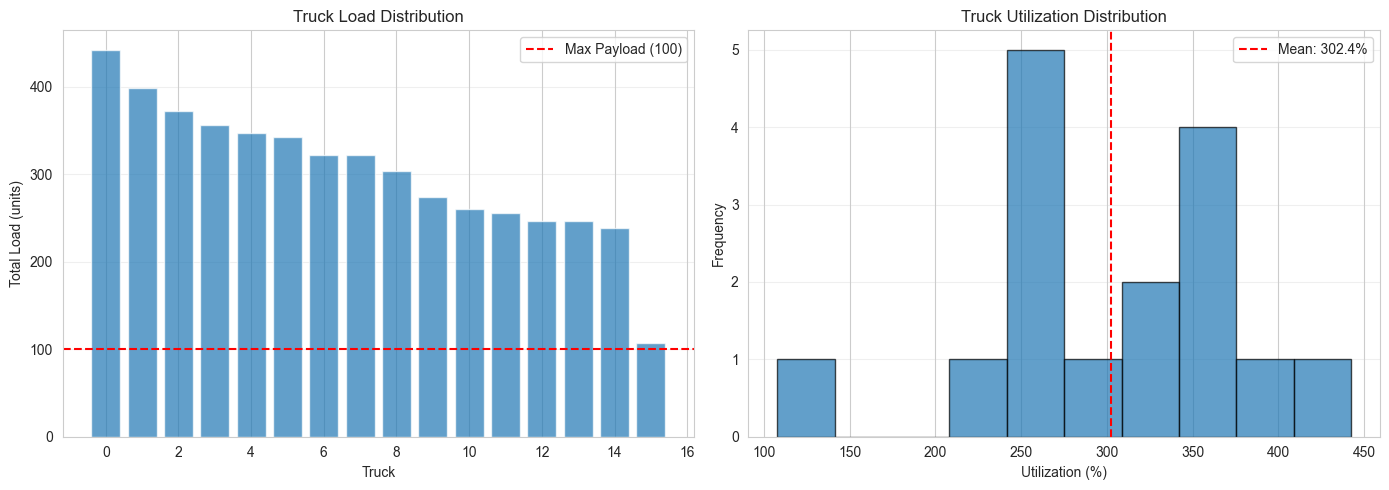

In [7]:
# Visualize truck loads
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart of truck loads
truck_loads = deliveries_with_trucks.groupby('truck')['units'].sum().sort_values(ascending=False)
axes[0].bar(range(len(truck_loads)), truck_loads.values, alpha=0.7)
axes[0].axhline(router.max_payload, color='red', linestyle='--', label=f'Max Payload ({router.max_payload})')
axes[0].set_xlabel('Truck')
axes[0].set_ylabel('Total Load (units)')
axes[0].set_title('Truck Load Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Histogram of utilization
utilization = (truck_loads / router.max_payload * 100)
axes[1].hist(utilization, bins=10, edgecolor='black', alpha=0.7)
axes[1].axvline(utilization.mean(), color='red', linestyle='--', label=f'Mean: {utilization.mean():.1f}%')
axes[1].set_xlabel('Utilization (%)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Truck Utilization Distribution')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 5. Optimize Delivery Routes

In [8]:
# Optimize routes using nearest neighbor heuristic
print("🗺️  Optimizing delivery routes...\n")
final_deliveries, routes = router.optimize_routes(deliveries_with_trucks)

print(f"✅ Optimized {len(routes)} routes")
print(f"\nRoute summary:")
print(routes)

🗺️  Optimizing delivery routes...

✅ Optimized 16 routes

Route summary:
       truck       route_order origin  \
0    truck_1        1, 2, 3, 4  08020   
1   truck_10     1, 2, 3, 4, 5  08020   
2   truck_11     1, 2, 3, 4, 5  08020   
3   truck_12  1, 2, 3, 4, 5, 6  08020   
4   truck_13     1, 2, 3, 4, 5  08020   
5   truck_14        1, 2, 3, 4  08020   
6   truck_15        1, 2, 3, 4  08020   
7   truck_16           1, 2, 3  08020   
8    truck_2        1, 2, 3, 4  08020   
9    truck_3     1, 2, 3, 4, 5  08020   
10   truck_4     1, 2, 3, 4, 5  08020   
11   truck_5        1, 2, 3, 4  08020   
12   truck_6        1, 2, 3, 4  08020   
13   truck_7        1, 2, 3, 4  08020   
14   truck_8     1, 2, 3, 4, 5  08020   
15   truck_9        1, 2, 3, 4  08020   

                                destinations  total_distance  
0                 13081, 13646, 18058, 19533           11513  
1          44934, 47680, 55458, 60447, 64326           56306  
2          47680, 55458, 64326, 74514, 7

In [9]:
# Analyze route efficiency
print("📊 Route Efficiency Metrics:")
print(f"\n   Total distance: {routes['total_distance'].sum():.2f} units")
print(f"   Average distance per route: {routes['total_distance'].mean():.2f} units")
print(f"   Min distance: {routes['total_distance'].min():.2f} units")
print(f"   Max distance: {routes['total_distance'].max():.2f} units")

# Deliveries per truck
deliveries_per_truck = final_deliveries.groupby('truck').size()
print(f"\n   Average deliveries per truck: {deliveries_per_truck.mean():.1f}")
print(f"   Min deliveries per truck: {deliveries_per_truck.min()}")
print(f"   Max deliveries per truck: {deliveries_per_truck.max()}")

📊 Route Efficiency Metrics:

   Total distance: 891258.00 units
   Average distance per route: 55703.62 units
   Min distance: 11513.00 units
   Max distance: 89215.00 units

   Average deliveries per truck: 5.4
   Min deliveries per truck: 3
   Max deliveries per truck: 7


## 6. Visualize Route Metrics

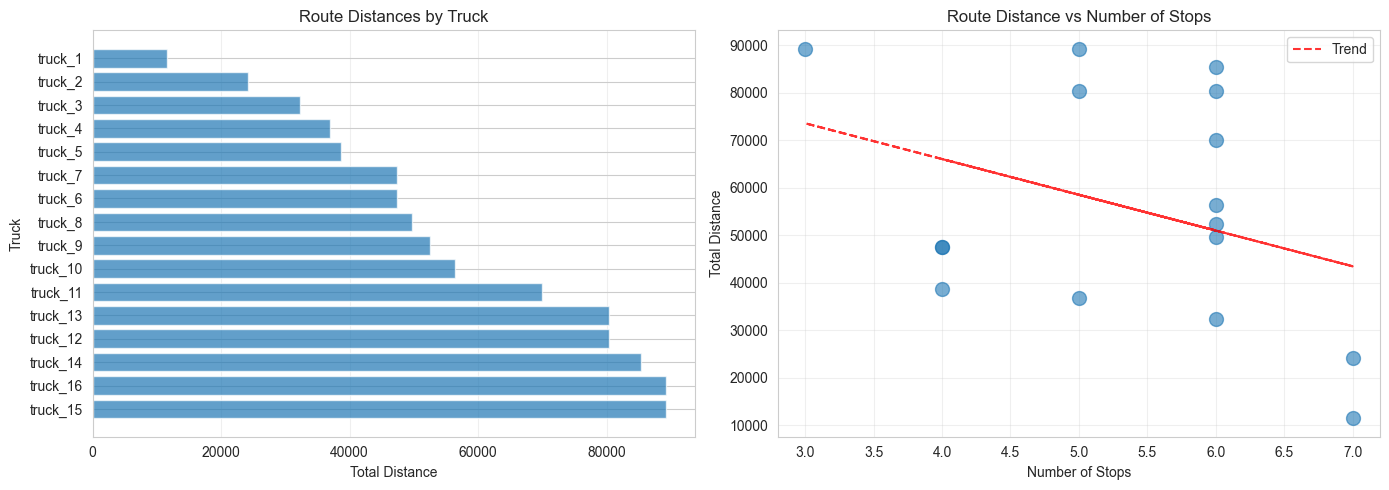

In [10]:
# Plot route distances
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart of route distances
routes_sorted = routes.sort_values('total_distance', ascending=False)
axes[0].barh(range(len(routes_sorted)), routes_sorted['total_distance'].values, alpha=0.7)
axes[0].set_yticks(range(len(routes_sorted)))
axes[0].set_yticklabels(routes_sorted['truck'].values)
axes[0].set_xlabel('Total Distance')
axes[0].set_ylabel('Truck')
axes[0].set_title('Route Distances by Truck')
axes[0].grid(True, alpha=0.3, axis='x')

# Scatter: Distance vs Number of Stops
stops_per_truck = final_deliveries.groupby('truck').size()
route_data = routes.merge(stops_per_truck.rename('stops'), left_on='truck', right_index=True)

axes[1].scatter(route_data['stops'], route_data['total_distance'], alpha=0.6, s=100)
axes[1].set_xlabel('Number of Stops')
axes[1].set_ylabel('Total Distance')
axes[1].set_title('Route Distance vs Number of Stops')
axes[1].grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(route_data['stops'], route_data['total_distance'], 1)
p = np.poly1d(z)
axes[1].plot(route_data['stops'], p(route_data['stops']), "r--", alpha=0.8, label='Trend')
axes[1].legend()

plt.tight_layout()
plt.show()

## 7. Analyze Customer Coverage

👥 Top 10 Customers by Volume:
           # Deliveries  Total Units  # Trucks
customer                                      
CUST_0003             6       486.05         6
CUST_0014             6       422.02         5
CUST_0005             5       306.15         5
CUST_0027             3       266.61         2
CUST_0021             4       241.97         3
CUST_0011             3       227.86         2
CUST_0024             4       193.43         3
CUST_0028             4       185.81         2
CUST_0017             3       180.02         2
CUST_0020             3       168.80         2


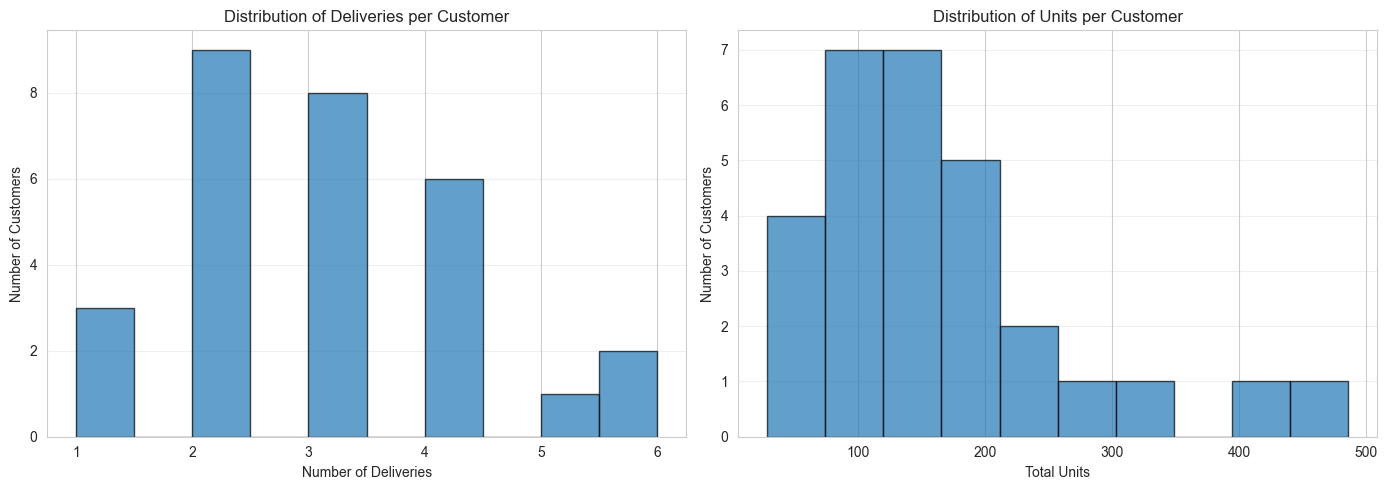

In [11]:
# Which customers receive deliveries?
customer_deliveries = final_deliveries.groupby('customer').agg({
    'units': ['count', 'sum'],
    'truck': 'nunique'
}).round(2)
customer_deliveries.columns = ['# Deliveries', 'Total Units', '# Trucks']
customer_deliveries = customer_deliveries.sort_values('Total Units', ascending=False)

print("👥 Top 10 Customers by Volume:")
print(customer_deliveries.head(10))

# Visualize customer distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Deliveries per customer
axes[0].hist(customer_deliveries['# Deliveries'], bins=10, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Number of Deliveries')
axes[0].set_ylabel('Number of Customers')
axes[0].set_title('Distribution of Deliveries per Customer')
axes[0].grid(True, alpha=0.3, axis='y')

# Units per customer
axes[1].hist(customer_deliveries['Total Units'], bins=10, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Total Units')
axes[1].set_ylabel('Number of Customers')
axes[1].set_title('Distribution of Units per Customer')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 8. Save Results

In [12]:
# Save deliveries and routes
deliveries_path = '../output/04_deliveries.csv'
routes_path = '../output/04_routes.csv'

final_deliveries.to_csv(deliveries_path, index=False)
routes.to_csv(routes_path, index=False)

print(f"✅ Deliveries saved to: {deliveries_path}")
print(f"   Total deliveries: {len(final_deliveries)}")
print(f"\n✅ Routes saved to: {routes_path}")
print(f"   Total routes: {len(routes)}")

✅ Deliveries saved to: ../output/04_deliveries.csv
   Total deliveries: 86

✅ Routes saved to: ../output/04_routes.csv
   Total routes: 16


## Summary

✅ Loaded demand forecasts

✅ Generated customer locations

✅ Distributed demand to customers

✅ Assigned deliveries to trucks with payload constraints

✅ Optimized delivery routes using nearest neighbor

✅ Analyzed route efficiency and customer coverage

✅ Saved delivery plan and routes

**Complete!** All stages of the supply chain optimization pipeline have been executed.